# Lagrangian Neural Networks

In this notebook, we train a Lagrangian Neural Network (LNN) based on the work by Cranmer et al. ([Cranmer et al.](https://doi.org/10.48550/arXiv.2003.04630)). The LNN is trained using data from a nonlinear Euler-Bernoulli beam to predict the positions and velocities of its mid-point and end-points.

The implementation leverages the following Python packages:
- [JAX](https://jax.readthedocs.io/en/latest/quickstart.html): A framework for scientific computing with automatic differentiation, vectorization, and parallelization.
- [Equinox](https://docs.kidger.site/equinox/): A JAX library for neural networks and more.
- [Diffrax](https://docs.kidger.site/diffrax/): A JAX library for numerical integration of ODEs (and SDEs, CDEs, and more).
- [Optax](https://optax.readthedocs.io/en/latest/): A gradient processing and optimization library for JAX, implementing popular optimizers like Adam and AdaBelief.

For more insights on LNNs, check out this [blog post](https://greydanus.github.io/2020/03/10/lagrangian-nns/) by Cranmer et al.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pickle
from functools import partial
from typing import Union, Callable, Generator, Literal

import jax
from jaxtyping import Array, PRNGKeyArray, PyTree
import jax.numpy as jnp
import jax.nn as jnn
import jax.random as jr
from jaxtyping import Array, PRNGKeyArray

import diffrax
import equinox as eqx

import optax

# Data Loading

The data is generated using MATLAB code, which simulates six different trajectories with amplitudes varying from -1 to +1. 

The data is loaded using the code below.

In [2]:
def dataprep(datafile, node):
    def create_path(i):
        filename = [filename for filename in os.listdir('Data/') if filename.startswith(str(i))][0]
        path1 = "Data/"
        path2 = filename

        return path1 + path2 + "/" + path2 + "_out.csv", path1 + path2 + "/" + path2 + "_U1_out.csv",path1 + path2 + "/" + path2 + "_U2_out.csv"

    def load_data(data_list, nodes):
        inp = np.empty((len(data_list), 1002, 2))
        pos = np.empty((len(data_list), 1002, len(nodes)))
        vel = np.empty((len(data_list), 1002, len(nodes)))
        acc = np.empty((len(data_list), 1002, len(nodes)))

        for i in range(len(data_list)):
            p,u1,u2 = create_path(data_list[i])
            pos[i] = np.loadtxt(open(p), delimiter=',', skiprows=1, usecols=(nodes)).reshape(-1, len(nodes))
            vel[i] = np.loadtxt(open(u1), delimiter=',', skiprows=1, usecols=(nodes)).reshape(-1, len(nodes))
            acc[i] = np.loadtxt(open(u2), delimiter=',', skiprows=1, usecols=(nodes)).reshape(-1, len(nodes))
        return pos,vel,acc

    pos, vel, acc = load_data(datafile, node)

    return pos, vel, acc

In [3]:
pos,vel,acc= dataprep([2220,2221,2222,2223,2224,2225], [0,17,18,33,34])
ts=pos[0,200:,0]
pos=pos[:,200:,1:]    #initial 200 values are dropped to analyze the data after the force is removed
vel=vel[:,200:,1:]
acc=acc[:,200:,1:]
print (np.shape(pos))
print (np.shape(vel))
print(np.shape(acc))

(6, 802, 4)
(6, 802, 4)
(6, 802, 4)


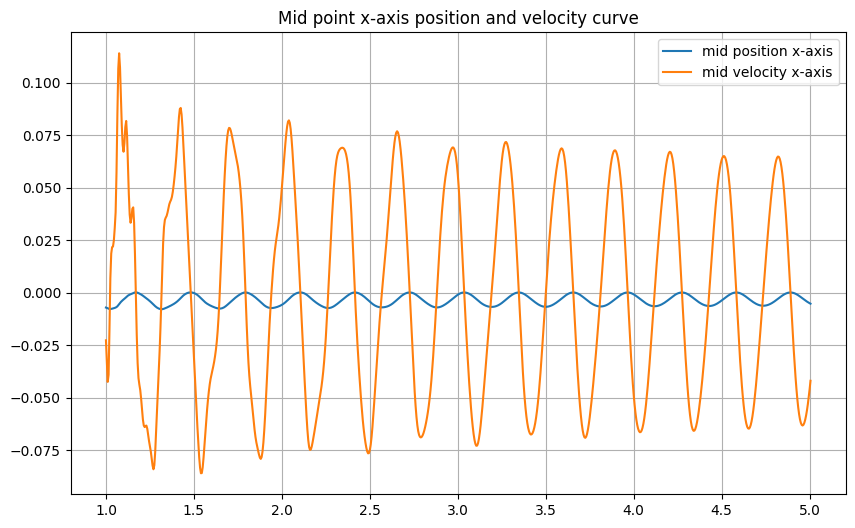

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(ts,pos[0,:,0], '-', label='mid position x-axis')
plt.plot(ts, vel[0,:,0], '-', label='mid velocity x-axis')
# plt.plot(ts, acc[0,:,0], '-', label='mid acc x-axis')
plt.title('Mid point x-axis position and velocity curve')
plt.legend()
plt.grid(True)
plt.show()

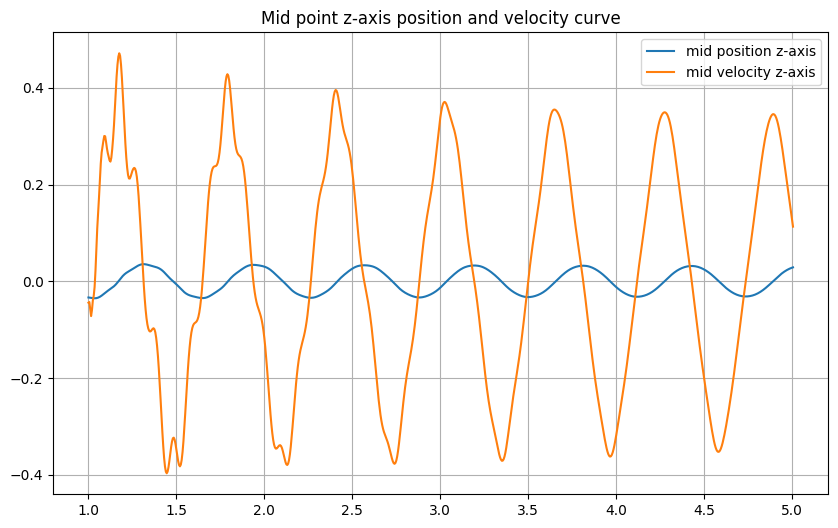

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(ts, pos[0,:,1], '-', label='mid position z-axis')
plt.plot(ts, vel[0,:,1], '-', label='mid velocity z-axis')
# plt.plot(ts, acc[0,:,1], '-', label='mid acc z-axis')
plt.title('Mid point z-axis position and velocity curve')
plt.legend()
plt.grid(True)
plt.show()

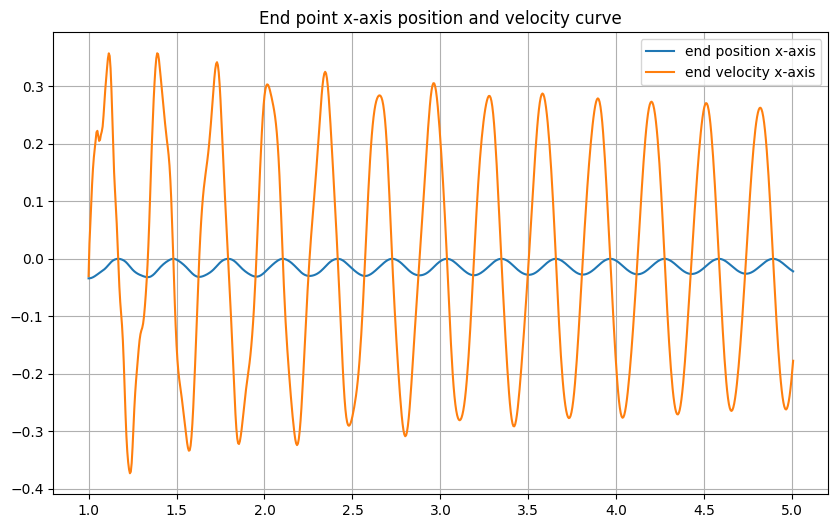

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(ts, pos[0,:,2], '-', label='end position x-axis')
plt.plot(ts, vel[0,:,2], '-', label='end velocity x-axis')
# plt.plot(ts, acc[0,:,2], '-', label='end acc x-axis')
plt.title('End point x-axis position and velocity curve')
plt.legend()
plt.grid(True)
plt.show()

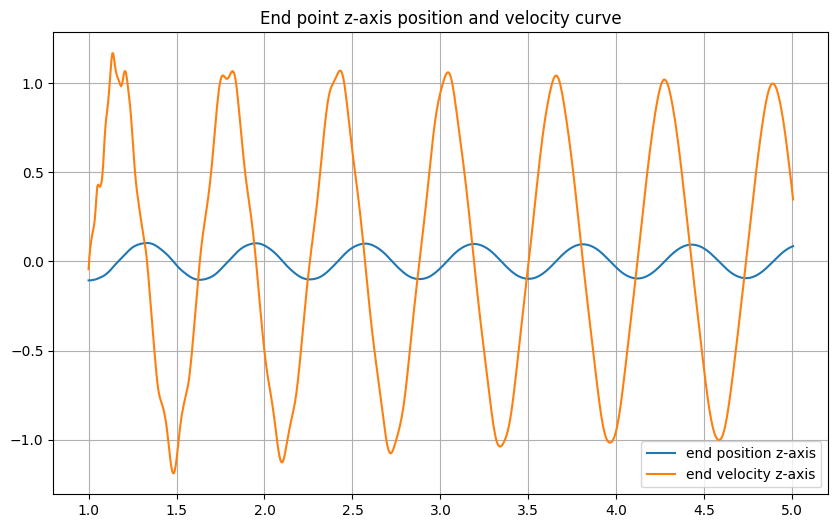

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(ts, pos[0,:,3], '-', label='end position z-axis')
plt.plot(ts, vel[0,:,3], '-', label='end velocity z-axis')
# plt.plot(ts, acc[0,:,3], '-', label='end acc z-axis')
plt.title('End point z-axis position and velocity curve')
plt.legend()
plt.grid(True)
plt.show()

# Training and Testing Data

The first five trajectories are used as training data, and the model will be tested on the sixth trajectory.

The input to the Lagrangian Neural Network (LNN) will be formatted as <span style="font-size:0.7em;">(`mid positions`, `end poditions`, `mid velocities`,`end velocities`)</span>.

In [8]:
pos_vel=jnp.concat((pos,vel),axis=-1)
vel_acc=jnp.concat((vel,acc),axis=-1)
train_data=(pos_vel[0:5,200:,:].reshape(-1, 8), vel_acc[0:5,200:,:].reshape(-1, 8))  #dropping 1sec more data for smoother curves for derivative fitting
test_inp=pos_vel[5,:,:].reshape(-1,8)
train_data[0].shape

(3010, 8)

## Define the Lagrangian Neural Network

In the following code, two classes are implemented. The `LNNs` class implements the Euler-Lagrange equation and parameterizes the Lagrangian $\mathcal{L}$ using a feed-forward neural network (FFNN, also known as MLP). When called, it maps the state vector $\bm{x}$ to its derivative:

$$\bm{x}=\begin{bmatrix}q_1\\q_2\\\dot{q}_1\\\dot{q}_2\end{bmatrix} \mapsto \dot{\bm{x}}=\begin{bmatrix}\dot{q}_1\\\dot{q}_2\\\ddot{q}_1\\\ddot{q}_2\end{bmatrix}$$

where $\ddot{q}$ is calculated via

$$\ddot{q} = (\nabla_{\dot{q}}\nabla_{\dot{q}}^T\mathcal{L})^{-1}[\nabla_q\mathcal{L} - (\nabla_q\nabla_{\dot{q}}^T\mathcal{L})\dot{q}]$$
Written in JAX, This equation is just a few lines of code
```
q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t)) @
        (jax.grad(lagrangian, 0)(q, q_t)
          - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
```

The second class, `ODESolver`, takes a function $f(y)$ and solves the ODE $\dot{y} = f(y)$, returning a time series of the solution. One can backpropagate through the solver (or use the adjoint method; see the Diffrax documentation for details).

In [9]:
class LNNs(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, state_size:int, *, key:PRNGKeyArray, nn_width:int=16, nn_depth:int=2):
        super().__init__()

        assert state_size%2==0
        self.mlp =eqx.nn.MLP(state_size, 1, nn_width, nn_depth, jnn.softplus, key=key)

    def lagrangian(self, q, q_t):
        state = jnp.concat([q, q_t], axis=-1)   
        lagranigan = self.mlp(state)           
        return jnp.squeeze(lagranigan)      

    def __call__(self, state):
        q, q_t = jnp.split(state, 2)
        q_tt = jax.numpy.linalg.pinv(jax.hessian(self.lagrangian, 1)(q, q_t)) @ (
                    jax.grad(self.lagrangian, 0)(q, q_t)
                    - jax.jacfwd(jax.grad(self.lagrangian, 1), 0)(q, q_t) @ q_t)
        return jnp.concat([q_t, q_tt])
    
class ODESolver(eqx.Module):
    func: eqx.Module
    stepsize_controller: diffrax.AbstractStepSizeController
    solver: diffrax.AbstractSolver

    def __init__(self, func, **kwargs):
        super().__init__()

        self.solver = kwargs.pop('solver', diffrax.Tsit5())
        self.stepsize_controller = kwargs.pop('stepsize_controller', diffrax.PIDController(rtol=1e-6, atol=1e-6))

        self.func = func

    def __call__(self, ts:Array, y0:Array,u:Array=None) -> Array:

        def _func(t, y, args):
            return self.func(y)

        # Solve the ODE using diffrax
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(_func),
            self.solver,
            t0=ts[0], t1=ts[-1], 
            dt0=ts[1] - ts[0], y0=y0,
            stepsize_controller=self.stepsize_controller,
            saveat=diffrax.SaveAt(ts=ts),
        )

        return solution.ys

## Training a Lagrangian Neural Network

There are two approaches to training Lagrangian Neural Networks (LNNs) or neural ODEs in general:

- **Derivative Fitting**
- **Trajectory Fitting**

However, training on trajectories is not feasible for freshly initialized LNNs because they tend to produce very stiff dynamics, causing the integrator to take many steps.

### Start with Derivative Fitting

Derivative fitting is the only feasible way to train a freshly initialized LNN. After training for a while, we can switch to trajectory fitting. Additionally, derivative fitting is generally much faster.

The following cell defines the training loops.

In [10]:
def _dataloader(data: PyTree, batch_size:int, *, key:PRNGKeyArray, batch_mask: PyTree=None) -> Generator[PyTree, None, None]:

    # Generate an all true batch mask if None was passed
    if batch_mask is None:
        batch_mask = jax.tree.map(lambda x: x is not None, data)

    # Split the pytree according to the batch mask
    batched_data, unbatched_data = eqx.partition(data, batch_mask)

    # Check that all batch_mask data has the same batch dimension
    arrays_with_batch_dimension = jax.tree.leaves(batched_data)
    if len(arrays_with_batch_dimension) == 0:
        raise ValueError('At least one array should have a batch dimension.')
    dataset_size = arrays_with_batch_dimension[0].shape[0]
    if not all(array.shape[0] == dataset_size for array in arrays_with_batch_dimension[1:]):
        raise ValueError('All arrays with a batch axis should have the same shape along that axis.')

    # Convert to Numpy arrays. Numpy's slicing is much faster than jax's, so for fast model training steps this actually makes a huge difference!
    batched_data = jax.tree.map(lambda x: np.array(x), batched_data) 

    batch_size = min(batch_size, dataset_size)  # Reduce batch size if the dataset has less examples than batch size
    indices = jnp.arange(dataset_size)

    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start, end = 0, batch_size
        while end <= dataset_size:
            batch_indices = perm[start:end]
            bs = jax.tree.map(lambda x: x[batch_indices], batched_data)
            yield eqx.combine(bs, unbatched_data)
            start = end
            end = start + batch_size


In [11]:

def mse(pred, target, model):
    return jnp.mean((pred-target)**2)

def fit(model: PyTree,
        x: Array|tuple[Array, ...],
        y: Array|tuple[Array, ...],
        *,
        key: PRNGKeyArray,
        validation_data: tuple[Array|tuple[Array, ...], Array|tuple[Array, ...]] = None,
        batch_size: int = 32,
        batch_mask: PyTree[bool]|None = None,
        # lr: float = 3e-3,
        steps: int = 1000,
        log_loss_every: int = 10,
        loss_fn: Callable = mse,
        optimizer: optax.GradientTransformation = optax.adabelief(1e-3),
        ):

    if batch_mask is None:
        model_in_axes = 0
    else:
        model_in_axes = (jax.tree.map(lambda x: 0 if x else None, batch_mask[0]),)

    @eqx.filter_jit
    def get_loss(model, x, y):
        y_pred = jax.vmap(model, in_axes=model_in_axes)(x)
        return loss_fn(y, y_pred, model)
    
    grad_loss = eqx.filter_value_and_grad(get_loss)

    @eqx.filter_jit
    def make_step(x, y, flat_model, optimizer, flat_opt_state):
        model = jax.tree_util.tree_unflatten(treedef_model, flat_model)
        opt_state = jax.tree_util.tree_unflatten(treedef_opt_state, flat_opt_state)

        loss, grads = grad_loss(model, x, y)
        updates, opt_state = optimizer.update(grads, opt_state, params=eqx.filter(model, eqx.is_inexact_array))
        model = eqx.apply_updates(model, updates)

        flat_model = jax.tree_util.tree_leaves(model)
        flat_opt_state = jax.tree_util.tree_leaves(opt_state)

        return loss, flat_model, flat_opt_state

    history = {'log_loss_every': log_loss_every,
               'loss': [],}
    if validation_data is not None:
        vx, vy = validation_data
        history['val_loss'] = []

    val_loss = None

    opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

    flat_model, treedef_model = jax.tree_util.tree_flatten(model)
    flat_opt_state, treedef_opt_state = jax.tree_util.tree_flatten(opt_state)

    start_time = time.time()
    for step, (xi, yi) in zip(range(steps), 
                              _dataloader((x, y), batch_size, batch_mask=batch_mask, key=key)):
        loss, flat_model, flat_opt_state = make_step(xi, yi, flat_model, optimizer, flat_opt_state)

        if (step % log_loss_every) == 0 or step == steps - 1:
            model = jax.tree_util.tree_unflatten(treedef_model, flat_model)
            train_loss = get_loss(model, x, y)
            history['loss'].append(train_loss)
            if validation_data is not None:
                val_loss = get_loss(model, vx, vy)
                history['val_loss'].append(val_loss)
                print(f"Step: {step}, Loss: {train_loss:.3e}, Validation loss: {val_loss:.3e}")
            else:
                print(f"Step: {step}, Loss: {train_loss:.3e}")

    model = jax.tree_util.tree_unflatten(treedef_model, flat_model)

    training_time = time.time() - start_time
    print(f'Training took: {training_time:-2f}s')

    return model, history

And here we train a LNN with the derivative fitting approach.

In [12]:
key = jr.key(0)

model_key, loader_key = jr.split(key, 2)

lnn = LNNs(8,key=model_key,nn_depth=3) 

lnn, losses_1 = fit(lnn, train_data[0],train_data[1], key=loader_key, steps=60000,log_loss_every=10, optimizer= optax.adabelief(3e-3))

Step: 0, Loss: 3.453e+01
Step: 10, Loss: 1.951e+01
Step: 20, Loss: 1.866e+01
Step: 30, Loss: 1.669e+01
Step: 40, Loss: 1.459e+01
Step: 50, Loss: 1.294e+01
Step: 60, Loss: 1.172e+01
Step: 70, Loss: 1.081e+01
Step: 80, Loss: 1.008e+01
Step: 90, Loss: 9.480e+00
Step: 100, Loss: 8.965e+00
Step: 110, Loss: 8.518e+00
Step: 120, Loss: 8.123e+00
Step: 130, Loss: 7.775e+00
Step: 140, Loss: 7.463e+00
Step: 150, Loss: 7.185e+00
Step: 160, Loss: 6.938e+00
Step: 170, Loss: 6.716e+00
Step: 180, Loss: 6.509e+00
Step: 190, Loss: 6.319e+00
Step: 200, Loss: 6.146e+00
Step: 210, Loss: 5.986e+00
Step: 220, Loss: 5.843e+00
Step: 230, Loss: 5.714e+00
Step: 240, Loss: 5.590e+00
Step: 250, Loss: 5.465e+00
Step: 260, Loss: 5.351e+00
Step: 270, Loss: 5.247e+00
Step: 280, Loss: 5.148e+00
Step: 290, Loss: 5.058e+00
Step: 300, Loss: 4.976e+00
Step: 310, Loss: 4.903e+00
Step: 320, Loss: 4.832e+00
Step: 330, Loss: 4.765e+00
Step: 340, Loss: 4.700e+00
Step: 350, Loss: 4.640e+00
Step: 360, Loss: 4.583e+00
Step: 370, L

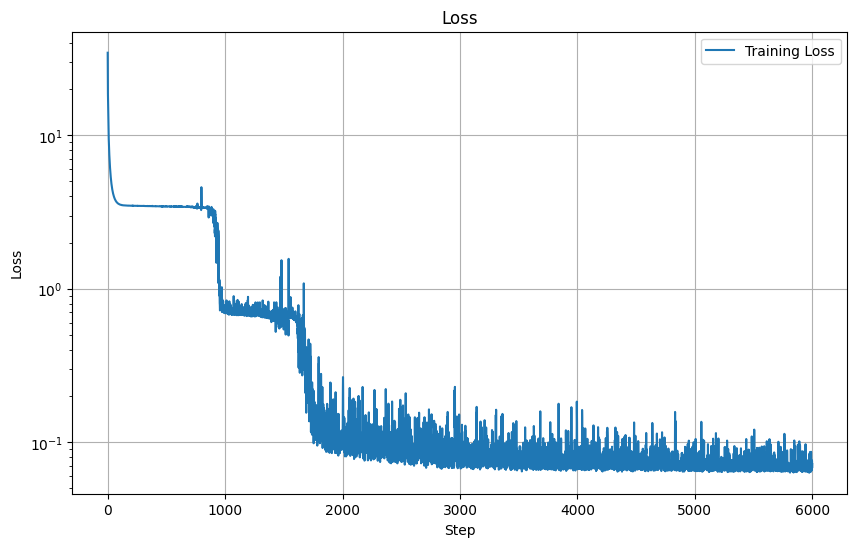

In [13]:
plt.figure(figsize=(10, 6))
plt.semilogy(losses_1['loss'], label='Training Loss')
plt.title('Loss'); plt.xlabel('Step'); plt.ylabel('Loss'); plt.grid(); plt.legend(); plt.show()

Let's integrate the model now

In [14]:
lnn_ode = ODESolver(lnn)
y_pred = lnn_ode(ts,test_inp[0])

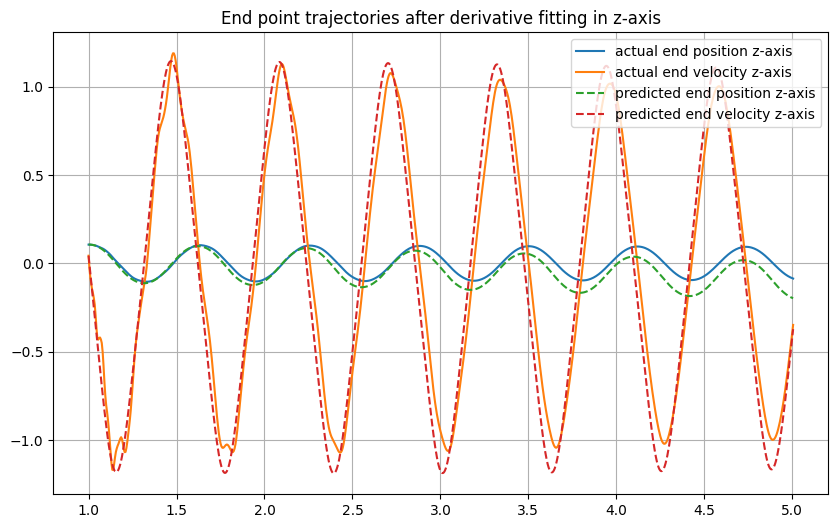

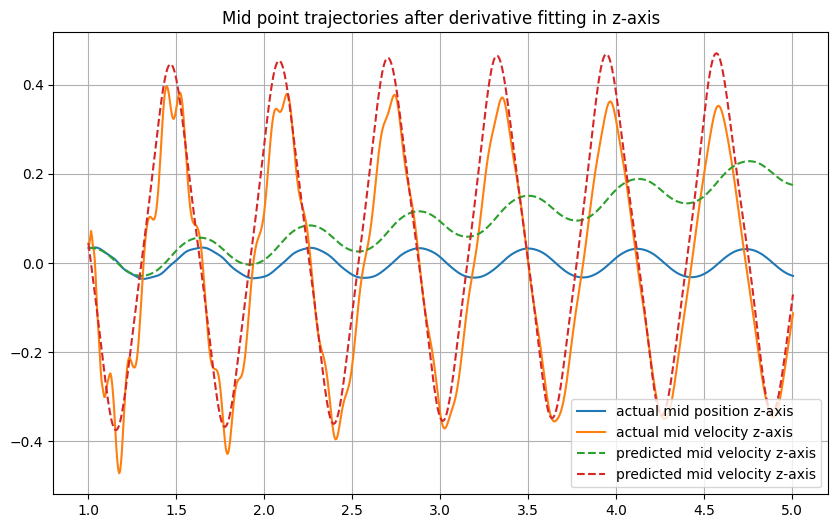

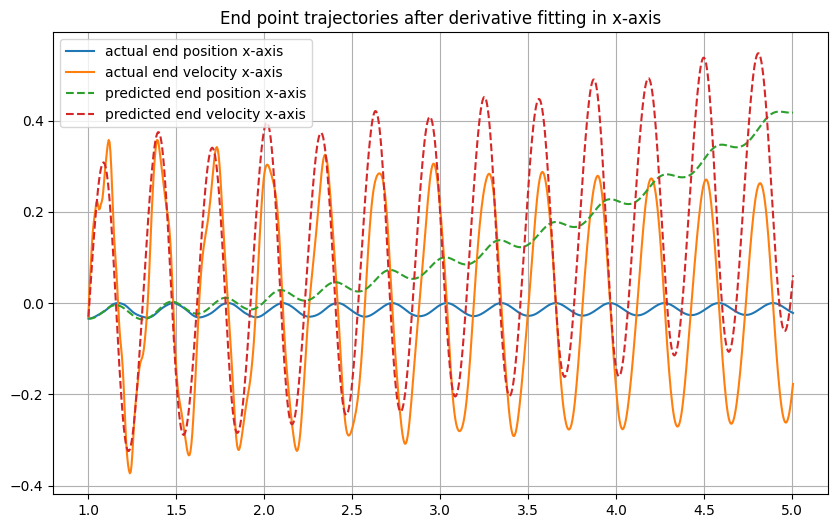

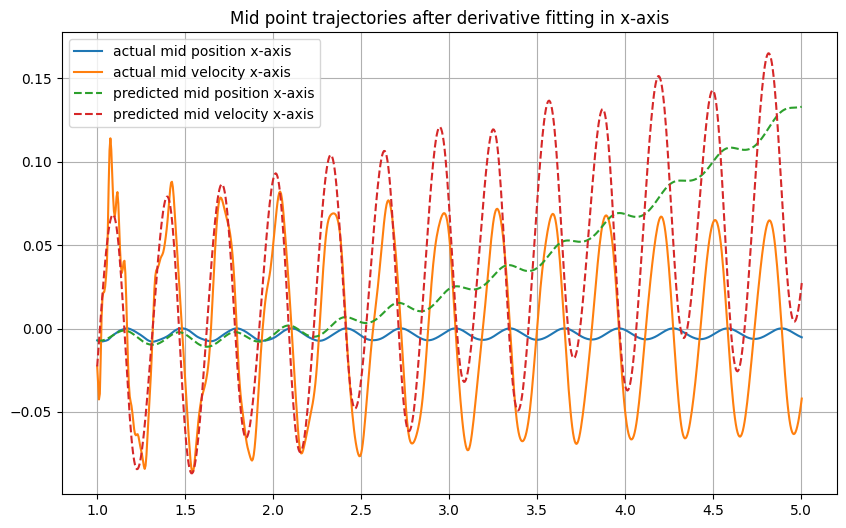

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(ts, test_inp[:,3], '-', label='actual end position z-axis')
plt.plot(ts, test_inp[:,7], '-', label='actual end velocity z-axis')
plt.plot(ts, y_pred[:,3],'--', label='predicted end position z-axis')
plt.plot(ts,y_pred[:,7],'--',label='predicted end velocity z-axis')
plt.title('End point trajectories after derivative fitting in z-axis')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(ts, test_inp[:,1], label='actual mid position z-axis')
plt.plot(ts, test_inp[:,5], label='actual mid velocity z-axis')
plt.plot(ts, y_pred[:,1],'--', label='predicted mid velocity z-axis')
plt.plot(ts,y_pred[:,5],'--',label='predicted mid velocity z-axis')
plt.title('Mid point trajectories after derivative fitting in z-axis')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(ts, test_inp[:,2], '-', label='actual end position x-axis')
plt.plot(ts, test_inp[:,6], '-', label='actual end velocity x-axis')
plt.plot(ts, y_pred[:,2],'--', label='predicted end position x-axis')
plt.plot(ts,y_pred[:,6],'--',label='predicted end velocity x-axis')
plt.title('End point trajectories after derivative fitting in x-axis')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(ts, test_inp[:,0], '-', label='actual mid position x-axis')
plt.plot(ts, test_inp[:,4], '-', label='actual mid velocity x-axis')
plt.plot(ts, y_pred[:,0],'--', label='predicted mid position x-axis')
plt.plot(ts,y_pred[:,4],'--',label='predicted mid velocity x-axis')
plt.title('Mid point trajectories after derivative fitting in x-axis')
plt.legend()
plt.grid(True)
plt.show()

The model is integrating, but the trajectories are not looking good.

## Trajectory fitting

Let's switch to trajectory fitting and fine-tune the network!

Below is the training loop to run on trajectory data.

In [16]:
@eqx.filter_value_and_grad
def grad_loss(model, ti, yi):
    y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:,0])
    return jnp.mean((yi - y_pred) ** 2)

@eqx.filter_jit
def make_step(ti, yi, model, optim, opt_state):
    loss, grads = grad_loss(model, ti, yi)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

def train(
    model, training_data,
    *, key,
    batch_size=32,
    lr=1e-4,
    steps=1000,
    print_every=100,
    ):

    ts, ys = training_data
    
    losses = []

    start_time = time.time()
    optim = optax.adabelief(lr)
    opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
    for step, (_ys,) in zip(
        range(steps), _dataloader((ys, ), batch_size, key=key)
    ):
        loss, model, opt_state = make_step(ts, _ys, model, optim, opt_state)
        losses.append(loss)
        if (step % print_every) == 0 or step == steps - 1:
            print(f"Step: {step}, Loss: {loss:.3e}")
    training_time = time.time() - start_time
    print(f'Training took: {training_time:-2f}s')

    return model, losses

Now let's train the LNNs on the trajectory data.

In [17]:
lnn_ode = ODESolver(lnn)
trajectory_data = (ts, pos_vel[0:5,:,:])

lnn_ode, losses = train(lnn_ode, trajectory_data, key=loader_key, steps=2000, lr=3e-3, print_every=50)

Step: 0, Loss: 1.781e-02
Step: 50, Loss: 1.030e-03
Step: 100, Loss: 6.224e-04
Step: 150, Loss: 5.540e-04
Step: 200, Loss: 5.107e-04
Step: 250, Loss: 4.816e-04
Step: 300, Loss: 4.607e-04
Step: 350, Loss: 4.447e-04
Step: 400, Loss: 4.316e-04
Step: 450, Loss: 4.206e-04
Step: 500, Loss: 4.111e-04
Step: 550, Loss: 4.032e-04
Step: 600, Loss: 3.965e-04
Step: 650, Loss: 3.910e-04
Step: 700, Loss: 3.864e-04
Step: 750, Loss: 3.826e-04
Step: 800, Loss: 3.793e-04
Step: 850, Loss: 3.766e-04
Step: 900, Loss: 3.741e-04
Step: 950, Loss: 3.719e-04
Step: 1000, Loss: 3.698e-04
Step: 1050, Loss: 3.683e-04
Step: 1100, Loss: 3.667e-04
Step: 1150, Loss: 3.648e-04
Step: 1200, Loss: 5.180e-04
Step: 1250, Loss: 3.631e-04
Step: 1300, Loss: 3.608e-04
Step: 1350, Loss: 4.233e-04
Step: 1400, Loss: 3.591e-04
Step: 1450, Loss: 3.575e-04
Step: 1500, Loss: 4.299e-04
Step: 1550, Loss: 3.565e-04
Step: 1600, Loss: 3.754e-04
Step: 1650, Loss: 3.629e-04
Step: 1700, Loss: 3.541e-04
Step: 1750, Loss: 3.737e-04
Step: 1800, Los

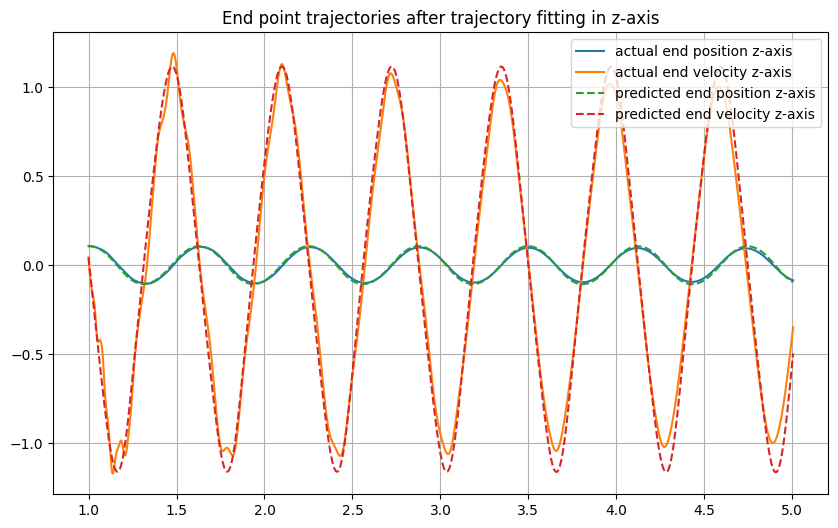

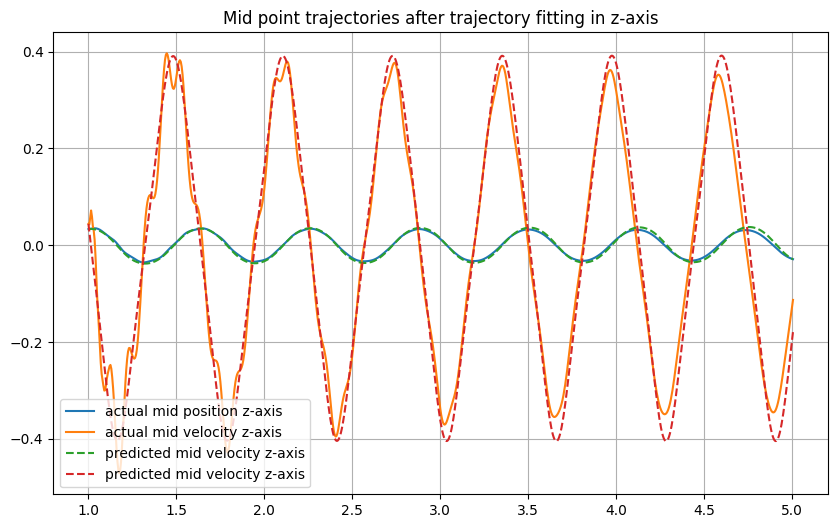

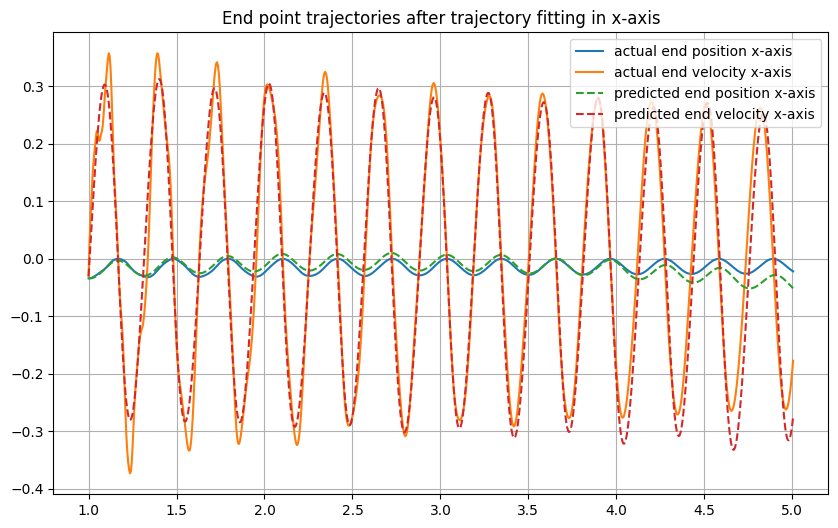

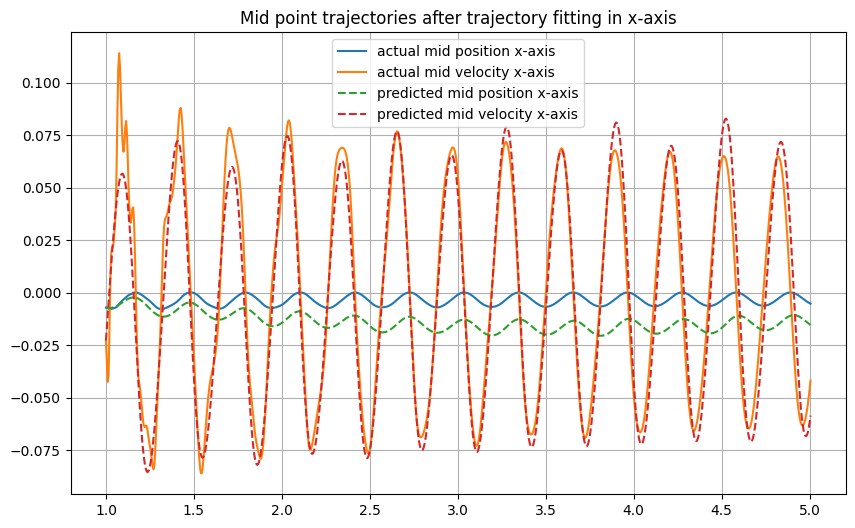

In [28]:
y_pred = lnn_ode(ts,test_inp[0])

plt.figure(figsize=(10, 6))
plt.plot(ts, test_inp[:,3], '-', label='actual end position z-axis')
plt.plot(ts, test_inp[:,7], '-', label='actual end velocity z-axis')
plt.plot(ts, y_pred[:,3],'--', label='predicted end position z-axis')
plt.plot(ts,y_pred[:,7],'--',label='predicted end velocity z-axis')
plt.title('End point trajectories after trajectory fitting in z-axis')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(ts, test_inp[:,1], label='actual mid position z-axis')
plt.plot(ts, test_inp[:,5], label='actual mid velocity z-axis')
plt.plot(ts, y_pred[:,1],'--', label='predicted mid velocity z-axis')
plt.plot(ts,y_pred[:,5],'--',label='predicted mid velocity z-axis')
plt.title('Mid point trajectories after trajectory fitting in z-axis')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(ts, test_inp[:,2], '-', label='actual end position x-axis')
plt.plot(ts, test_inp[:,6], '-', label='actual end velocity x-axis')
plt.plot(ts, y_pred[:,2],'--', label='predicted end position x-axis')
plt.plot(ts,y_pred[:,6],'--',label='predicted end velocity x-axis')
plt.title('End point trajectories after trajectory fitting in x-axis')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(ts, test_inp[:,0], '-', label='actual mid position x-axis')
plt.plot(ts, test_inp[:,4], '-', label='actual mid velocity x-axis')
plt.plot(ts, y_pred[:,0],'--', label='predicted mid position x-axis')
plt.plot(ts,y_pred[:,4],'--',label='predicted mid velocity x-axis')
plt.title('Mid point trajectories after trajectory fitting in x-axis')
plt.legend()
plt.grid(True)
plt.show()

Now let's try predicting ahead in time.

In [22]:
ts1 = jnp.arange(1.0, 10.005, 0.005)
y_pred = lnn_ode(ts1,test_inp[0])

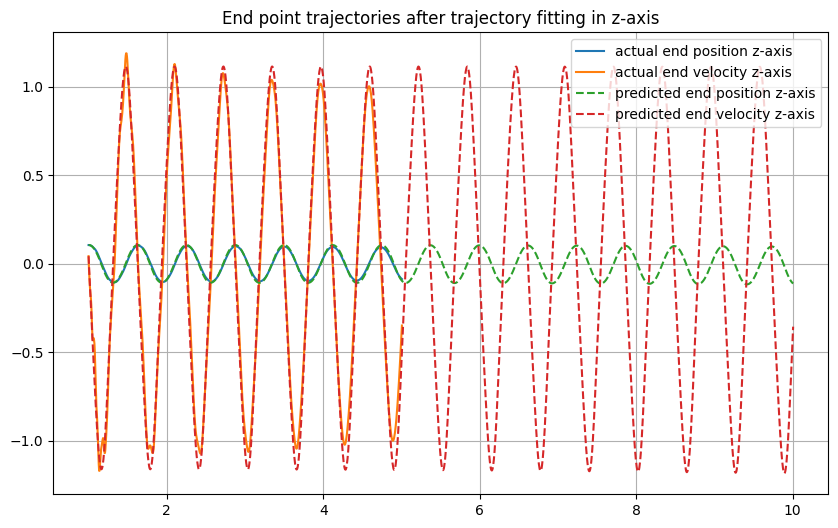

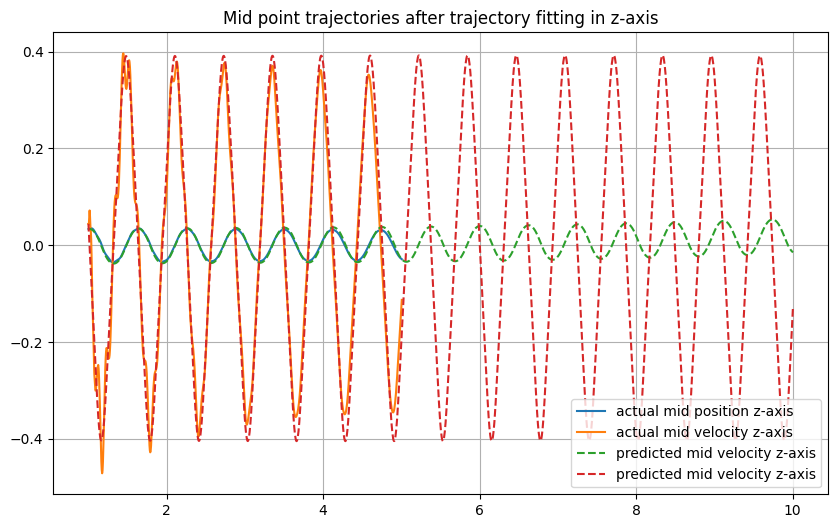

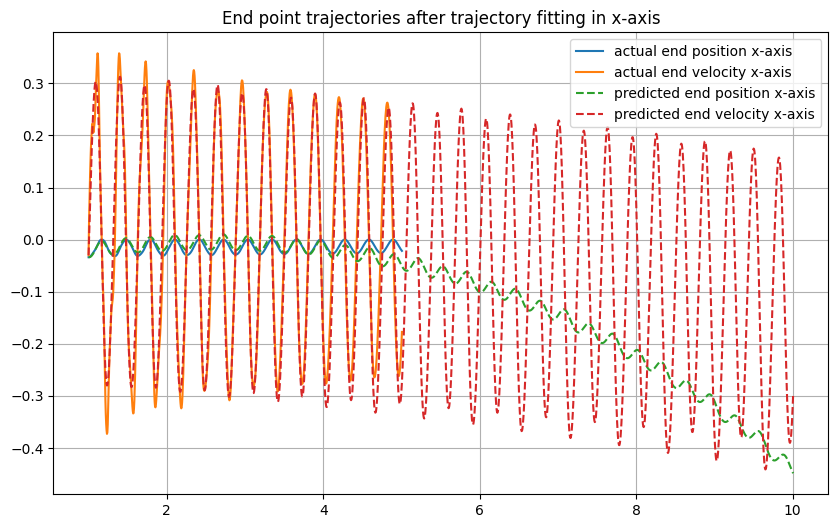

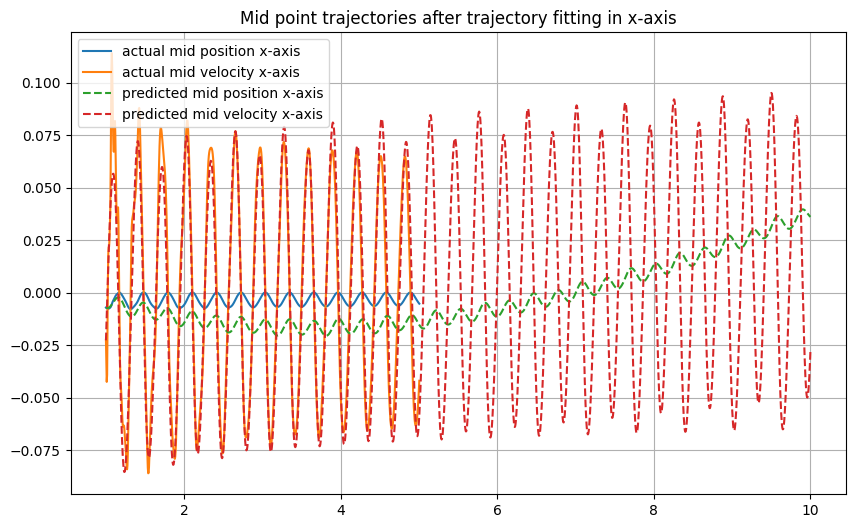

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(ts, test_inp[:,3], '-', label='actual end position z-axis')
plt.plot(ts, test_inp[:,7], '-', label='actual end velocity z-axis')
plt.plot(ts1, y_pred[:,3],'--', label='predicted end position z-axis')
plt.plot(ts1,y_pred[:,7],'--',label='predicted end velocity z-axis')
plt.title('End point trajectories after trajectory fitting in z-axis')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(ts, test_inp[:,1], label='actual mid position z-axis')
plt.plot(ts, test_inp[:,5], label='actual mid velocity z-axis')
plt.plot(ts1, y_pred[:,1],'--', label='predicted mid velocity z-axis')
plt.plot(ts1,y_pred[:,5],'--',label='predicted mid velocity z-axis')
plt.title('Mid point trajectories after trajectory fitting in z-axis')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(ts, test_inp[:,2], '-', label='actual end position x-axis')
plt.plot(ts, test_inp[:,6], '-', label='actual end velocity x-axis')
plt.plot(ts1, y_pred[:,2],'--', label='predicted end position x-axis')
plt.plot(ts1,y_pred[:,6],'--',label='predicted end velocity x-axis')
plt.title('End point trajectories after trajectory fitting in x-axis')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(ts, test_inp[:,0], '-', label='actual mid position x-axis')
plt.plot(ts, test_inp[:,4], '-', label='actual mid velocity x-axis')
plt.plot(ts1, y_pred[:,0],'--', label='predicted mid position x-axis')
plt.plot(ts1,y_pred[:,4],'--',label='predicted mid velocity x-axis')
plt.title('Mid point trajectories after trajectory fitting in x-axis')
plt.legend()
plt.grid(True)
plt.show()